In [1]:
from config.configuration import engine
from tools import idealista_functions as i_func
import pandas as pd
import numpy as np
import h2o
from h2o.automl import H2OAutoML
import seaborn as sns

Conectado a mysql / base de datos: tu_pisito


In [4]:
mysql_df = pd.read_sql_query(
f"""
SELECT sq_mt_built, 
        n_rooms, 
        n_bathrooms, 
        apartments.latitude, 
        apartments.longitude, 
        is_new_development, 
        is_renewal_needed, 
        has_lift, 
        is_exterior, 
        has_parking, 
        floor, 
        house_type_id,
        value_m2,
        neighborhood_name,
        district_name,
        buy_price
FROM apartments
LEFT JOIN neighborhoods
ON apartments.neighborhood_id = neighborhoods.neighborhood_id
LEFT JOIN districts
ON neighborhoods.district_id = districts.district_id
WHERE apartment_id > 9130
ORDER BY apartment_id DESC;
""", engine)

In [5]:
# Let's rename two columns:

mysql_df = mysql_df.rename(columns = {
    "neighborhood_name": "neighborhood",
    "district_name": "district"
       })

In [6]:
mysql_df["log_buy_price"] = np.log10(mysql_df.buy_price)

In [12]:
mysql_df.shape

(274, 17)

In [30]:
# Export data to CSV:

# mysql_df.to_csv("./data/mysql_df_log.csv", index = False)

In [31]:
# Droping columns innecesary columns

mysql_df.drop("buy_price", axis=1, inplace=True)

In [8]:
mysql_df.columns

Index(['sq_mt_built', 'n_rooms', 'n_bathrooms', 'latitude', 'longitude',
       'is_new_development', 'is_renewal_needed', 'has_lift', 'is_exterior',
       'has_parking', 'floor', 'house_type_id', 'value_m2', 'neighborhood',
       'district', 'buy_price', 'log_buy_price'],
      dtype='object')

In [9]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.11" 2021-04-20; OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.20.04); OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.20.04, mixed mode, sharing)
  Starting server from /home/ccastrob/anaconda3/envs/ironhack/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmprg1r01gp
  JVM stdout: /tmp/tmprg1r01gp/h2o_ccastrob_started_from_python.out
  JVM stderr: /tmp/tmprg1r01gp/h2o_ccastrob_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Madrid
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.4
H2O_cluster_version_age:,"21 days, 2 hours and 6 minutes"
H2O_cluster_name:,H2O_from_python_ccastrob_2wx9av
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.963 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


In [10]:
saved_model = h2o.load_model("./models/GBM_grid__1_AutoML_20210728_185537_model_16")

In [13]:
df_pred = mysql_df
df_pred.shape

(274, 17)

In [14]:
h2o_df = h2o.H2OFrame(df_pred)
predictions = saved_model.predict(h2o_df)
h2o_df["prediction"] = predictions

Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


In [15]:
final_df = h2o_df.as_data_frame()
final_df["buy_prediction"] = 10**final_df.prediction
final_df = final_df.astype({"buy_prediction": int})

In [16]:
final_df["error"] = final_df["buy_price"] - final_df["buy_prediction"]
final_df["abs_error"] = abs(final_df["buy_price"] - final_df["buy_prediction"])
final_df["per_error"] = (final_df["error"] / final_df["buy_price"]) * 100
final_df["per_abs_error"] = (final_df["abs_error"] / final_df["buy_price"]) * 100
final_df["good_purchase"] = final_df["error"] < 0

In [17]:
cols = ["buy_price", "prediction", "error", "per_error", "good_purchase", "abs_error", "per_abs_error", "buy_prediction"]
final_df[cols].sample(20)

,buy_price,prediction,error,per_error,good_purchase,abs_error,per_abs_error,buy_prediction
89,149000,5.193506,-7137,-4.789933,True,7137,4.789933,156137
25,1250000,5.961723,334364,26.749120,False,334364,26.749120,915636
64,2450000,6.343403,245028,10.001143,False,245028,10.001143,2204972
209,535000,5.729877,-1879,-0.351215,True,1879,0.351215,536879
97,559000,5.712598,43062,7.703399,False,43062,7.703399,515938
220,175000,5.302717,-25778,-14.730286,True,25778,14.730286,200778
225,196500,5.292630,332,0.168957,False,332,0.168957,196168
126,450000,5.569267,79092,17.576000,False,79092,17.576000,370908
176,850000,5.897038,61072,7.184941,False,61072,7.184941,788928
28,1030000,6.063550,-127577,-12.386117,True,127577,12.386117,1157577


In [18]:
final_df.per_abs_error.mean()

10.211302058627938

<AxesSubplot:xlabel='buy_price', ylabel='per_error'>

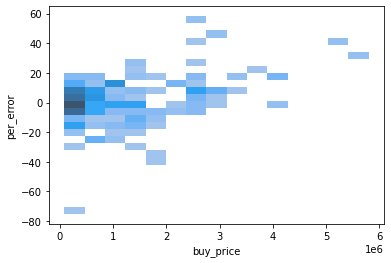

In [19]:
sns.histplot(x=final_df["buy_price"], y=final_df["per_error"])

<AxesSubplot:xlabel='buy_price', ylabel='per_abs_error'>

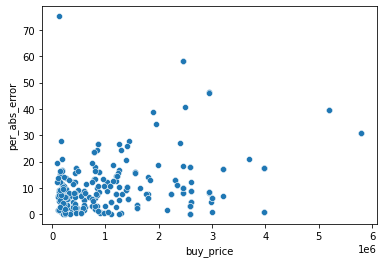

In [20]:
sns.scatterplot(x=final_df["buy_price"], y=final_df["per_abs_error"])

In [27]:
df_test = final_df[final_df["per_abs_error"] > 10]

<AxesSubplot:xlabel='buy_price', ylabel='per_abs_error'>

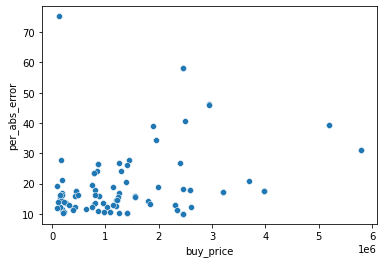

In [28]:
sns.scatterplot(x=df_test["buy_price"], y=df_test["per_abs_error"])

<AxesSubplot:xlabel='buy_price', ylabel='Count'>

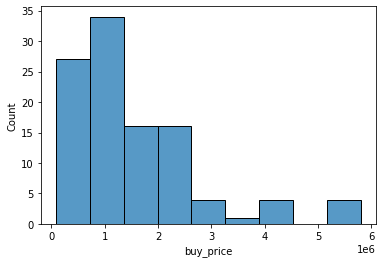

In [30]:
sns.histplot(x=df_test["buy_price"])

In [34]:
(final_df["buy_price"] > 3000000).value_counts()

False    260
True      14
Name: buy_price, dtype: int64

In [32]:
final_df[final_df["per_abs_error"] > 70]

,sq_mt_built,n_rooms,n_bathrooms,latitude,longitude,is_new_development,is_renewal_needed,has_lift,is_exterior,has_parking,...,district,buy_price,log_buy_price,prediction,buy_prediction,error,abs_error,per_error,per_abs_error,good_purchase
21,25,1,1,40.4301,-3.71274,0,1,1,1,0,...,Chamberí,129000,5.11059,5.354167,226030,-97030,97030,-75.217054,75.217054,True


In [39]:
final_df[(final_df["buy_price"] < 1000000) & (final_df["per_error"] < -20)]

,sq_mt_built,n_rooms,n_bathrooms,latitude,longitude,is_new_development,is_renewal_needed,has_lift,is_exterior,has_parking,...,district,buy_price,log_buy_price,prediction,buy_prediction,error,abs_error,per_error,per_abs_error,good_purchase
1,259,6,3,40.4543,-3.69262,0,1,1,1,1,...,Tetuán,860000,5.934498,6.036689,1088151,-228151,228151,-26.529186,26.529186,True
18,234,6,3,40.4615,-3.69291,0,0,1,1,0,...,Tetuán,785000,5.894870,5.986685,969807,-184807,184807,-23.542293,23.542293,True
21,25,1,1,40.4301,-3.71274,0,1,1,1,0,...,Chamberí,129000,5.110590,5.354167,226030,-97030,97030,-75.217054,75.217054,True
42,234,6,3,40.4615,-3.69291,0,0,1,1,0,...,Tetuán,785000,5.894870,5.986685,969807,-184807,184807,-23.542293,23.542293,True
62,234,6,3,40.4615,-3.69291,0,0,1,1,0,...,Tetuán,785000,5.894870,5.986685,969807,-184807,184807,-23.542293,23.542293,True
87,133,3,2,40.3661,-3.70370,0,0,0,1,1,...,Usera,187000,5.271842,5.354859,226390,-39390,39390,-21.064171,21.064171,True
124,259,6,3,40.4543,-3.69262,0,1,1,1,1,...,Tetuán,860000,5.934498,6.036689,1088151,-228151,228151,-26.529186,26.529186,True
162,188,4,4,40.4613,-3.66843,0,1,1,1,1,...,Chamartín,850000,5.929419,6.023716,1056127,-206127,206127,-24.250235,24.250235,True
173,234,6,3,40.4615,-3.69291,0,0,1,1,0,...,Tetuán,785000,5.894870,5.986685,969807,-184807,184807,-23.542293,23.542293,True
235,83,2,1,40.3863,-3.74015,0,0,1,1,0,...,Carabanchel,162000,5.209515,5.315713,206877,-44877,44877,-27.701852,27.701852,True


In [41]:
final_df[(final_df["buy_price"] >= 1000000) & (final_df["buy_price"] < 2000000) & (final_df["per_error"] < -30)]

,sq_mt_built,n_rooms,n_bathrooms,latitude,longitude,is_new_development,is_renewal_needed,has_lift,is_exterior,has_parking,...,district,buy_price,log_buy_price,prediction,buy_prediction,error,abs_error,per_error,per_abs_error,good_purchase
112,754,7,6,40.4623,-3.64042,0,0,0,0,1,...,Hortaleza,1950000,6.290035,6.418551,2621505,-671505,671505,-34.436154,34.436154,True
120,754,7,6,40.4604,-3.63692,0,0,0,0,1,...,Hortaleza,1900000,6.278754,6.421873,2641635,-741635,741635,-39.033421,39.033421,True


In [42]:
final_df[(final_df["buy_price"] >= 2000000) & (final_df["per_error"] < -5)]

,sq_mt_built,n_rooms,n_bathrooms,latitude,longitude,is_new_development,is_renewal_needed,has_lift,is_exterior,has_parking,...,district,buy_price,log_buy_price,prediction,buy_prediction,error,abs_error,per_error,per_abs_error,good_purchase
40,448,6,5,40.4504,-3.69052,0,0,1,1,1,...,Chamartín,2225000,6.34733,6.379782,2397627,-172627,172627,-7.758517,7.758517,True
60,448,6,5,40.4504,-3.69052,0,0,1,1,1,...,Chamartín,2225000,6.34733,6.379782,2397627,-172627,172627,-7.758517,7.758517,True


In [47]:
final_df[(final_df["buy_price"] < 1000000) & (final_df["per_abs_error"] < 5)]

,sq_mt_built,n_rooms,n_bathrooms,latitude,longitude,is_new_development,is_renewal_needed,has_lift,is_exterior,has_parking,...,district,buy_price,log_buy_price,prediction,buy_prediction,error,abs_error,per_error,per_abs_error,good_purchase
0,153,4,2,40.4852,-3.70415,0,0,1,1,0,...,Fuencarral,550000,5.740363,5.735726,544159,5841,5841,1.062000,1.062000,False
4,46,1,1,40.4551,-3.70532,0,0,1,1,0,...,Tetuán,214000,5.330414,5.320310,209079,4921,4921,2.299533,2.299533,False
13,181,5,3,40.4544,-3.69309,0,1,1,1,1,...,Tetuán,795000,5.900367,5.890824,777721,17279,17279,2.173459,2.173459,False
23,147,5,3,40.4314,-3.73221,0,0,1,1,0,...,Moncloa,545000,5.736397,5.743583,554093,-9093,9093,-1.668440,1.668440,True
32,216,5,3,40.4419,-3.71455,0,1,1,1,1,...,Chamberí,899000,5.953760,5.956777,905267,-6267,6267,-0.697108,0.697108,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,103,2,2,40.3836,-3.71358,0,0,1,1,0,...,Usera,215000,5.332438,5.338537,218040,-3040,3040,-1.413953,1.413953,True
251,78,3,1,40.3906,-3.73650,0,0,0,1,0,...,Carabanchel,146000,5.164353,5.151408,141712,4288,4288,2.936986,2.936986,False
252,97,1,1,40.3937,-3.75262,0,0,1,1,1,...,Latina,249000,5.396199,5.394633,248103,897,897,0.360241,0.360241,False
253,115,3,1,40.3851,-3.74290,0,0,1,1,0,...,Carabanchel,235000,5.371068,5.379949,239855,-4855,4855,-2.065957,2.065957,True


In [48]:
(final_df["buy_price"] < 1000000).value_counts()

True     157
False    117
Name: buy_price, dtype: int64